In [1]:
from stableemrifisher.fisher import StableEMRIFisher
from stableemrifisher.plot import CovEllipsePlot, cov_ellipse
from few.waveform import GenerateEMRIWaveform
from lisatools.detector import EqualArmlengthOrbits, ESAOrbits
from few.trajectory.inspiral import EMRIInspiral
from few.trajectory.ode import KerrEccEqFlux
import matplotlib.pyplot as plt
import os
import logging
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
from psd_utils import load_psd, get_psd_kwargs, load_psd_from_file
use_gpu=True
cp.cuda.Device(3).use()

startup


<CUDA Device 3>

In [2]:
logger = logging.getLogger()

In [3]:
traj = EMRIInspiral(func=KerrEccEqFlux)

In [15]:
# Intrinsic parameters
M = 1e6
mu = 50
a = 0.9
p0 = 15.5 
e0 = 0.0
x0 = 0.0
Y0 = np.cos(x0)

A = 1.92000000e-05
nr = 8.0

qK = 1.734812
phiK = 3.200417
qS = 0.542088
phiS = 5.357656
dist = 0.75 * 3.227111605827252 

Phi_phi0 = 3.0
Phi_theta0 = 1.0
Phi_r0 = 3*np.pi/4

dt = 10.0
Tobs = 4

In [16]:
t, p, e, x, Phi_phi, Phi_r, Phi_theta = traj(M, mu, a, p0, e0, Y0, dt=1e-13, T=Tobs)
p[-1]

3.8271103613569992

In [17]:
inspiral_kwargs_vac = {
        "DENSE_STEPPING": 0,
        "max_init_len": int(1e4),
        "err": 1e-13,  # To be set within the class
        #"use_rk4": True,
        }

# keyword arguments for summation generator (AAKSummation)
sum_kwargs = {
            "force_backend": 'cuda12x', # GPU is available for this type of summation
            "pad_output": True
    }

waveform_kwargs = {
            "T": Tobs,
            "dt": dt,
            #"eps": eps,
    }


waveform_vac_model = GenerateEMRIWaveform('FastKerrEccentricEquatorialFlux', return_list=False, inspiral_kwargs=inspiral_kwargs, sum_kwargs=sum_kwargs, force_backend = 'cuda12x')

In [58]:
waveform = waveform_model(M, mu, a, p0, e0, Y0, 
                          dist, qS, phiS, qK, phiK, 
                          Phi_phi0, Phi_theta0, Phi_r0, 
                          dt=dt, T=Tobs)

In [14]:
psd_wrap = load_psd_from_file("LISASensAv.npy", xp = cp)

Using gpu backend for PSD interpolation
PSD range [1.5291251e-47] [1.7328605e-32]


In [61]:
#varied parameters
param_names = ['M', 'mu', 'a', 'p0', 'e0', 'Phi_phi0', 'Phi_r0']

In [ ]:
#initialization
fish = StableEMRIFisher(M, mu, a, p0, e0, x0, dis, qS, phiS, qK, phiK,
              Phi_phi0, Phi_theta0, Phi_r0, dt=dt, T=Tobs, EMRI_waveform_gen=waveform_model, der_order=8, Ndelta=20, noise_model=psd_wrap, 
              param_names=param_names, stats_for_nerds=False, use_gpu=True,
              filename='test_outdir_2', CovMat=False, CovEllipse=False, live_dangerously=False, stability_plot=False)

#execution
fish()

wave ndim:  1
Computing SNR for parameters: {'M': 1000000.0, 'mu': 10, 'a': 0.998, 'p0': 7.7275, 'e0': 0.73, 'xI0': 1.0, 'dist': 3.83, 'qS': 0.5, 'phiS': 1.2, 'qK': 0.8, 'phiK': 0.2, 'Phi_phi0': 1.0, 'Phi_theta0': 0.0, 'Phi_r0': 3.0, 'CovMat': False}
Waveform Generated. SNR: 204.35685119280768
calculating stable deltas...
Time taken to compute stable deltas is 257.4217827320099 seconds
calculating Fisher matrix...
Finished derivatives
Calculated Fisher is *atleast* positive-definite.
Time taken to compute FM is 12.44217562675476 seconds


array([[ 1.86686768e+07, -8.37691427e+11,  9.77829772e+12,
         4.41658489e+12,  1.49624594e+13, -2.97359299e+06,
        -3.94986130e+05],
       [-8.37691427e+11,  3.76152923e+16, -4.39617693e+17,
        -1.98206806e+17, -6.70595858e+17,  1.32868845e+11,
         1.67844147e+10],
       [ 9.77829772e+12, -4.39617693e+17,  5.14995906e+18,
         2.31426834e+18,  7.81264980e+18, -1.54156301e+12,
        -1.76303157e+11],
       [ 4.41658489e+12, -1.98206806e+17,  2.31426834e+18,
         1.04490098e+18,  3.53897275e+18, -7.03099475e+11,
        -9.21852920e+10],
       [ 1.49624594e+13, -6.70595858e+17,  7.81264980e+18,
         3.53897275e+18,  1.20159935e+19, -2.40087774e+12,
        -3.44953292e+11],
       [-2.97359299e+06,  1.32868845e+11, -1.54156301e+12,
        -7.03099475e+11, -2.40087774e+12,  4.91441877e+05,
         7.74938498e+04],
       [-3.94986130e+05,  1.67844147e+10, -1.76303157e+11,
        -9.21852920e+10, -3.44953292e+11,  7.74938498e+04,
         5.9584801

In [90]:
Fisher1 = np.load('test_outdir/Fisher.npy')
covmat1 = np.linalg.inv(Fisher1)

Fisher2 = np.load('test_outdir_2/Fisher.npy')
covmat2 = np.linalg.inv(Fisher2)

Fisher3 = np.load('test_outdir_3/Fisher.npy')
covmat3 = np.linalg.inv(Fisher3)

In [34]:
def normal(mean, var, x):
    return np.exp(-(mean-x)**2/var/2)

def CovEllipsePlotHere(param_names, wave_params, covariance_list, labels=None):
    fig, axs = plt.subplots(len(param_names), len(param_names), figsize=(20, 20))

    colors = ['blue', 'red', 'green', 'purple', 'orange']  # Add more colors if needed

    if labels is None:
        labels = [f'Covariance {i+1}' for i in range(len(covariance_list))]

    # Loop over each covariance matrix
    for idx, covariance in enumerate(covariance_list):
        color = colors[idx % len(colors)]  # Cycle through colors if more covariances than colors
        label = labels[idx]

        # Ensure covariance is a 2D array
        covariance = np.atleast_2d(covariance)

        # First param index
        for i in range(len(param_names)):
            # Second param index
            for j in range(i, len(param_names)):

                if i != j:
                    cov = np.array(((covariance[i][i], covariance[i][j]), (covariance[j][i], covariance[j][j])))
                    mean = np.array((wave_params[param_names[i]], wave_params[param_names[j]]))

                    cov_ellipse(mean, cov, axs[j, i], lw=2, edgecolor=color, label=label if i == 0 and j == 1 else "")

                    # Custom setting the x-y lim for each plot
                    axs[j, i].set_xlim([wave_params[param_names[i]] - 2.5 * np.sqrt(covariance[i][i]),
                                        wave_params[param_names[i]] + 2.5 * np.sqrt(covariance[i][i])])
                    axs[j, i].set_ylim([wave_params[param_names[j]] - 2.5 * np.sqrt(covariance[j][j]),
                                        wave_params[param_names[j]] + 2.5 * np.sqrt(covariance[j][j])])

                    axs[j, i].set_xlabel(param_names[i], labelpad=20, fontsize=16)
                    axs[j, i].set_ylabel(param_names[j], labelpad=20, fontsize=16)

                else:
                    mean = wave_params[param_names[i]]
                    var = covariance[i][i]

                    x = np.linspace(mean - 3 * np.sqrt(var), mean + 3 * np.sqrt(var))

                    axs[j, i].plot(x, normal(mean, var, x), c=color, label=label if i == 0 and j == 0 else "")
                    axs[j, i].set_xlim([wave_params[param_names[i]] - 2.5 * np.sqrt(covariance[i][i]),
                                        wave_params[param_names[i]] + 2.5 * np.sqrt(covariance[i][i])])
                    axs[j, i].set_xlabel(param_names[i], labelpad=20, fontsize=16)
                    if i == j and j == 0:
                        axs[j, i].set_ylabel(param_names[i], labelpad=20, fontsize=16)

    for ax in fig.get_axes():
        ax.label_outer()

    for i in range(len(param_names)):
        for j in range(i + 1, len(param_names)):
            fig.delaxes(axs[i, j])

    # Collect handles and labels for the legend
    handles, labels = [], []
    for ax in fig.get_axes():
        for handle, label in zip(*ax.get_legend_handles_labels()):
            if label not in labels:
                handles.append(handle)
                labels.append(label)

    # Add legend to the figure
    fig.legend(handles, labels, loc='center right', fontsize=16)
    plt.tight_layout
    plt.show()

In [66]:
wave_params = {'M':M,
               'mu':mu,
               'a':a,
               'p0':p0,
               'e0':e0,
               'Phi_phi0':Phi_phi0,
               'Phi_r0':Phi_r0}

In [86]:
3*np.diag(covmat1), 3*np.diag(covmat2), 3*np.diag(covmat3)

(array([4.05991547e+03, 9.86733685e-08, 2.19100643e-13, 6.60018585e-11,
        4.23496870e-11, 2.16706913e-03, 7.32090467e-04]),
 array([3.35471026e+03, 8.22143565e-08, 1.80042695e-13, 5.39907600e-11,
        3.69260760e-11, 2.15981396e-03, 7.41099008e-04]),
 array([4.69429591e+03, 1.13725579e-07, 2.49245183e-13, 7.58549490e-11,
        4.90160704e-11, 2.16874862e-03, 7.41608353e-04]))

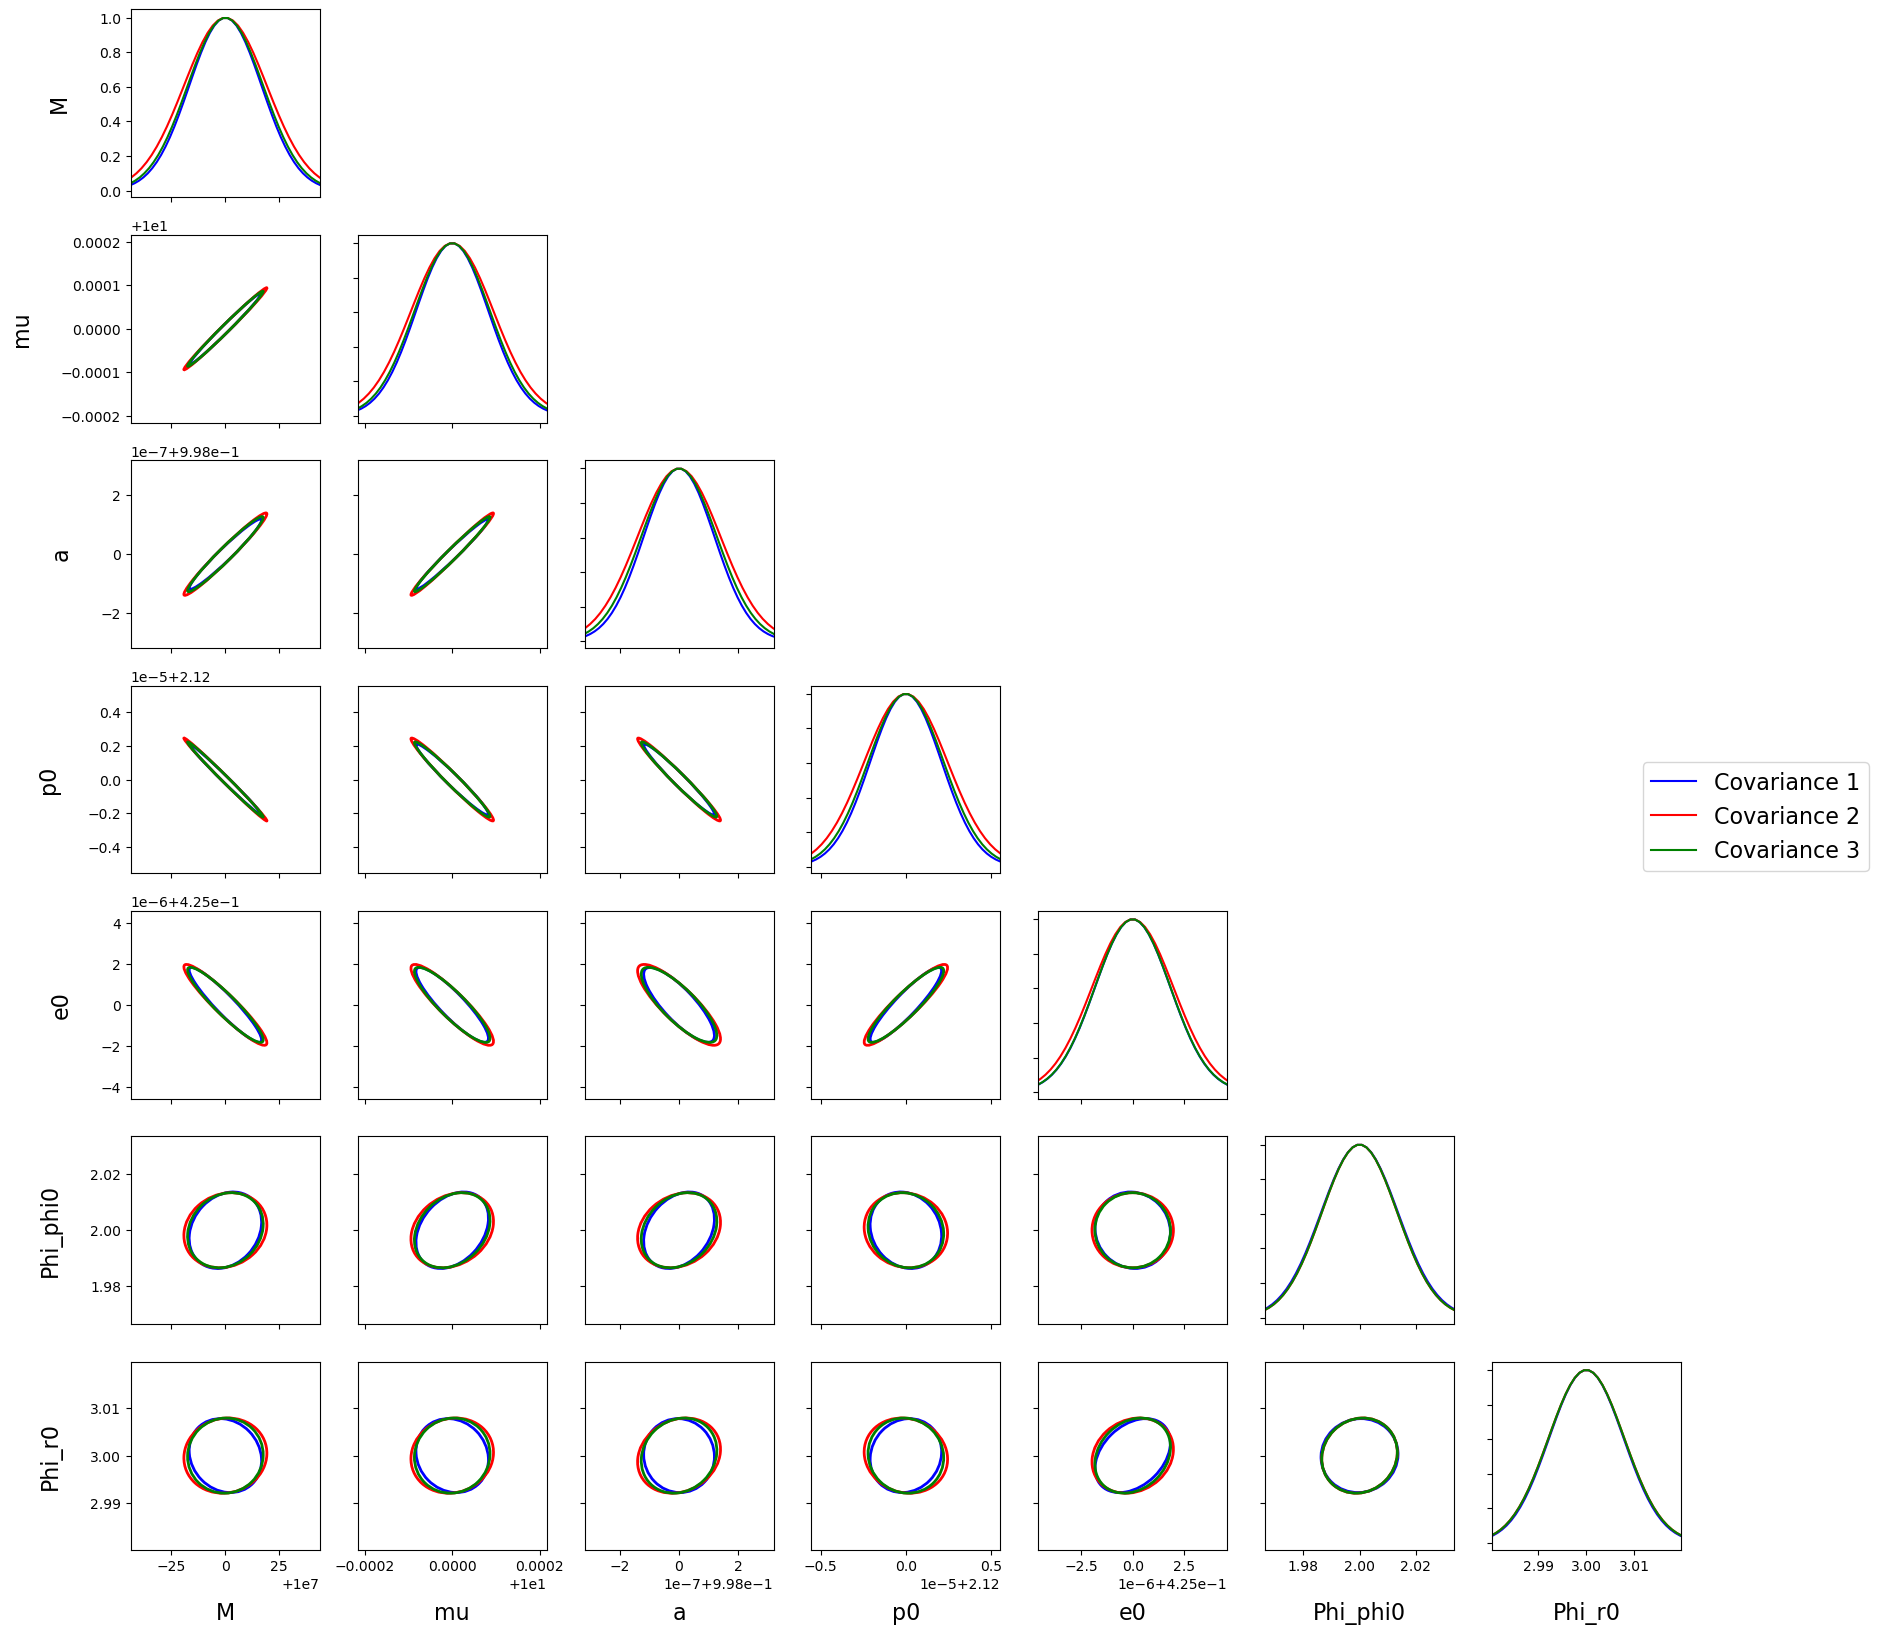

In [91]:
CovEllipsePlotHere(param_names, wave_params, [covmat1, covmat2, covmat3])

# Power Law Example

In [3]:
from stableemrifisher.fisher import StableEMRIFisher
from stableemrifisher.plot import CovEllipsePlot, cov_ellipse
from few.waveform import GenerateEMRIWaveform
from lisatools.detector import EqualArmlengthOrbits, ESAOrbits
from few.trajectory.inspiral import EMRIInspiral
from few.trajectory.ode import KerrEccEqFlux
import matplotlib.pyplot as plt
import os
import logging
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
from psd_utils import load_psd, get_psd_kwargs, load_psd_from_file
use_gpu=True
cp.cuda.Device(0).use()

startup


<CUDA Device 0>

In [4]:
class KerrEccEqFluxPowerLaw(KerrEccEqFlux):
    def modify_rhs(self, ydot, y):
        # in-place modification of the derivatives
        LdotAcc = (
            -self.additional_args[0]
            * pow(y[0] / 10.0, self.additional_args[1])
            * 32.0
            / 5.0
            * pow(y[0], -7.0 / 2.0)
        )
        dL_dp = (
            -3 * pow(a, 3)
            + pow(a, 2) * (8 - 3 * y[0]) * np.sqrt(y[0])
            + (-6 + y[0]) * pow(y[0], 2.5)
            + 3 * a * y[0] * (-2 + 3 * y[0])
        ) / (2.0 * pow(2 * a + (-3 + y[0]) * np.sqrt(y[0]), 1.5) * pow(y[0], 1.75))
        # transform back to pdot from Ldot abd add GW contribution
        # ydot[0] = (1+ LdotAcc/dL_dp) * ydot[0]
        ydot[0] = ydot[0] + LdotAcc / dL_dp

In [5]:
traj = EMRIInspiral(func=KerrEccEqFluxPowerLaw)

In [17]:
# Intrinsic parameters
M = 1e6
mu = 50
a = 0.9
p0 = 15.5 
e0 = 0.0
x0 = 0.0
Y0 = np.cos(x0)

A = 0 #1.92000000e-05
nr = 8.0

qK = 1.734812
phiK = 3.200417
qS = 0.542088
phiS = 5.357656
dist = 0.75 * 3.227111605827252 

Phi_phi0 = 3.0
Phi_theta0 = 1.0
Phi_r0 = 3*np.pi/4

dt = 10.0
Tobs = 4

In [7]:
t_vac, p_vac, e_vac, x_vac, Phi_phi_vac, Phi_r_vac, Phi_theta_vac = traj(M, mu, a, p0, e0, Y0, 0*A, nr , dt=1e-13, T=Tobs)
t_acc, p_acc, e_acc, x_acc, Phi_phi_acc, Phi_r_acc, Phi_theta_acc = traj(M, mu, a, p0, e0, Y0, A, nr , dt=1e-13, T=Tobs)
p_vac[-1], p_acc[-1], Phi_phi_vac[-1], Phi_phi_acc[-1]

(3.8271103613569992, 3.772208299944517, 645324.3692841905, 645966.898913163)

In [8]:
inspiral_kwargs_acc = {
        "DENSE_STEPPING": 0,
        "max_init_len": int(1e4),
        "err": 1e-13,  # To be set within the class
        "func": KerrEccEqFluxPowerLaw,
        }

# keyword arguments for summation generator (AAKSummation)
sum_kwargs = {
            "force_backend": 'cuda12x', # GPU is available for this type of summation
            "pad_output": True
    }

waveform_kwargs = {
            "T": Tobs,
            "dt": dt,
            #"eps": eps,
    }


waveform_acc_model = GenerateEMRIWaveform('FastKerrEccentricEquatorialFlux', return_list=False, inspiral_kwargs=inspiral_kwargs_acc, sum_kwargs=sum_kwargs, force_backend = 'cuda12x')


In [9]:
psd_wrap = load_psd_from_file("LISASensAv.npy", xp = cp)

Using gpu backend for PSD interpolation
PSD range [1.5291251e-47] [1.7328605e-32]


In [15]:
#varied parameters
param_names = ['M', 'mu', 'a', 'p0', 'Phi_phi0', 'A']

In [ ]:
#initialization
fish = StableEMRIFisher(M, mu, a, p0, e0, Y0, 2*dist, qS, phiS, qK, phiK,
              Phi_phi0, Phi_theta0, Phi_r0, dt=dt, T=Tobs, extra_param_args = [A, nr], extra_param_keys= ["A", "nr"], EMRI_waveform_gen=waveform_acc_model, der_order=4, Ndelta=24, noise_model=psd_wrap, 
              param_names=param_names, stats_for_nerds=False, use_gpu=True,
              filename='testacc_outdir_2', CovMat=False, CovEllipse=True, live_dangerously=False, stability_plot=False)

#execution
fish()

wave ndim:  1
Computing SNR for parameters: {'M': 1000000.0, 'mu': 50, 'a': 0.9, 'p0': 15.5, 'e0': 0.0, 'xI0': 1.0, 'dist': 4.840667408740878, 'qS': 0.542088, 'phiS': 5.357656, 'qK': 1.734812, 'phiK': 3.200417, 'Phi_phi0': 3.0, 'Phi_theta0': 1.0, 'Phi_r0': 2.356194490192345, 'A': 0, 'nr': 8.0}
Waveform Generated. SNR: 61.09140926201015
calculating stable deltas...
